In [1]:
import csv
import numpy as np
import torch
import pandas as pd
import torch.nn.functional as F
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import string
from tqdm.auto import tqdm
from PIL import Image
import sys
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from torch.utils.tensorboard import SummaryWriter

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.emit_nvtx(False)

# Utility

In [3]:
writer = SummaryWriter()

In [4]:
dev = torch.device('cuda:0')

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Datasets

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, csvfile, image_dir, transform=None):
        self.annotations = pd.read_csv(csvfile)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(os.path.join(self.image_dir, self.annotations.iloc[idx, 1]), self.annotations.iloc[idx, 0])
        sample = plt.imread(img_path)
        target = string.ascii_lowercase.find(self.annotations.iloc[idx, 1])

        if self.transform:
            sample = self.transform(sample)

        return sample, target

In [6]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(lambda e: np.transpose(e, axes=(1, 0, 2))),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(num_output_channels=1)
    ]
)
train_dataset = MyDataset('train_annot.csv', 'images\\train', transform)
test_dataset = MyDataset('test_annot.csv', 'images\\test', transform)

# Train / Test Loop

In [7]:
def train(model, optimizer, data):
    t_loss = []
    t_accuracy = []
    
    for x_train, y_train in data:
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        
        with torch.no_grad():
            t_loss.append(loss.cpu().numpy())
            t_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).cpu().numpy().tolist())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
            
    return t_loss, np.mean(t_accuracy)

In [8]:
def validate(model, data):
    val_loss = []
    val_accuracy = []
    
    with torch.no_grad():
        for x_val, y_val in data:
            y_pred = model(x_val)
            loss = F.cross_entropy(y_pred, y_val)
            val_loss.append(loss.cpu().numpy())
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())
                
        return val_loss, np.mean(val_accuracy)

In [9]:
def test(model, optimizer, batch_size, epochs=5, scheduler=None):
    train_d = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), dev)
    val_d = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True), dev)
    
    for epoch in range(epochs):
        t_loss, t_acc = train(model, optimizer, train_d)
        v_loss, v_acc = validate(model, val_d)

        if scheduler:
            scheduler.step()

        writer.add_scalar(f'Loss/train', np.mean(t_loss), epoch)
        writer.add_scalar(f'Accuracy/train', np.mean(t_acc), epoch)
        writer.add_scalar(f'Loss/test', np.mean(v_loss), epoch)
        writer.add_scalar(f'Accuracy/test', np.mean(v_acc), epoch)

    print(f"Epoches passed: {epochs} | Loss: {np.mean(v_loss)} | Accuracy: {np.mean(v_acc)}")


# Задание 1

## 1.1 Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями

Начальная конфигурация сети с двумя скрытыми слоями. В качестве оптимизатора выбран AdamW, т. к. некоторые начальные попытки показали что он почти всегда лучше отрабатывает, чем SGD :)
Остальные параметры выбраны случайно



In [10]:
batch_size = 256
lr = 0.001

model_2layer = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 1024), # input layer
    nn.ReLU(),
    nn.Linear(1024, 512), # first hidden layer
    nn.ReLU(),
    nn.Linear(512, 128),  # second hidden layer
    nn.ReLU(),    
    nn.Linear(128, 26)    # output layer
).to(dev)

optimizier = torch.optim.AdamW(model_2layer.parameters(), lr=lr)

In [11]:
test(model_2layer, optimizier, batch_size, 15)

Epoches passed: 15 | Loss: 0.36946195363998413 | Accuracy: 0.9062307692307693


После нескольких экспериментов с размером сети и размером батча пришел к такой конфигурации.
Также добавил шедулер, что бы сеть меньше переобучалась на поздних эпохах.

In [12]:
batch_size = 128
lr = 0.001

model_2layer = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 2048), # input layer
    nn.ReLU(),
    nn.Linear(2048, 784), # first hidden layer
    nn.ReLU(),
    nn.Linear(784, 256),  # second hidden layer
    nn.ReLU(),    
    nn.Linear(256, 26)    # output layer
).to(dev)

optimizier = torch.optim.AdamW(model_2layer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizier, gamma=0.7)

In [13]:
test(model_2layer, optimizier, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.2871815860271454 | Accuracy: 0.9197692307692308


Для сети с тремя слоями выбрал похожие параметры

In [14]:
batch_size = 128
lr = 0.001

model_3layer = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 2048), # input layer
    nn.ReLU(),
    nn.Linear(2048, 1024), # first hidden layer
    nn.ReLU(),
    nn.Linear(1024, 512),  # second hidden layer
    nn.ReLU(),    
    nn.Linear(512, 256),  # third hidden layer
    nn.ReLU(),    
    nn.Linear(256, 26)    # output layer
).to(dev)

optimizier = torch.optim.AdamW(model_3layer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizier, gamma=0.7)

In [15]:
test(model_3layer, optimizier, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.32005906105041504 | Accuracy: 0.9208461538461539


## 1.2 Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.

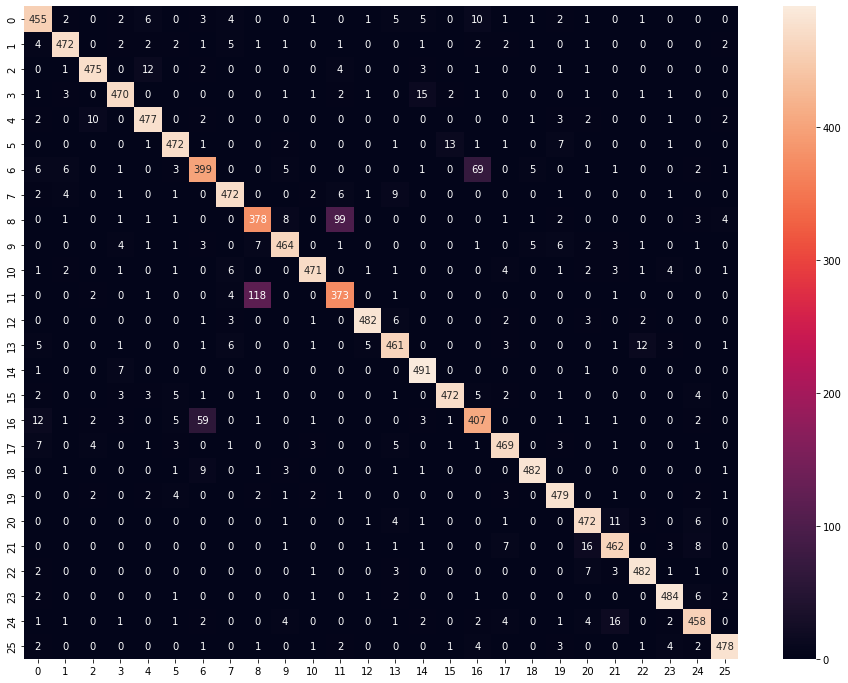

In [16]:
data = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size), dev)
model = model_2layer

predictions = np.array([])
labels = np.array([])

with torch.no_grad():
    for x_val, y_val in data:
        predictions = np.append(predictions, torch.argmax(model(x_val), dim=-1).cpu().numpy())
        labels = np.append(labels, y_val.cpu().numpy())
        
matrix = confusion_matrix(labels, predictions)

plt.figure(figsize=(16, 12))
heatmap(matrix, annot=True, fmt='g')
plt.show()

Из матрицы видно, что хуже всего детектируются буквы "i" и "g".
Отлично детектруются "t", "w" и "x"

## 1.3 Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.

In [17]:
alphabet = [l for l in string.ascii_lowercase]
pairs = []
for i in range(26):
    for j in range(i + 1, 26):
        if matrix[i][j] or matrix[j][i]:
            pairs.append([alphabet[i], alphabet[j], max(matrix[i][j], matrix[j][i])])
                
pairs.sort(key=lambda x: -x[2])
pairs[0:10]

[['i', 'l', 118],
 ['g', 'q', 69],
 ['u', 'v', 16],
 ['v', 'y', 16],
 ['d', 'o', 15],
 ['f', 'p', 13],
 ['a', 'q', 12],
 ['c', 'e', 12],
 ['n', 'w', 12],
 ['g', 's', 9]]

Как видно на картинке ниже, эти буквы имеют общие черты, поэтому иногда путаются моделью

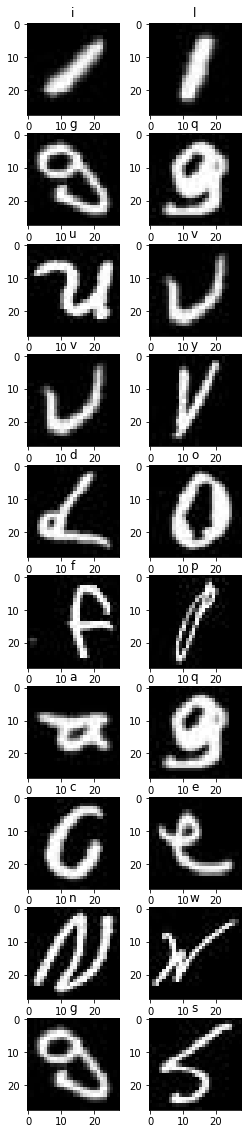

In [18]:
results = predictions == labels
test_images = MyDataset('test_annot.csv', 'images\\test', transform=lambda x: np.transpose(x, axes=(1, 0, 2)))
fig = plt.figure(figsize=(4, 20))

n = 1
for p in pairs[0:10]:
    for l in range(2):
        range_s = 500*(ord(p[l])-ord('a'))
        for i in range(range_s, range_s + 500):
            if not results[i]:
                s, t = test_images[i]
                fig.add_subplot(10, 2, n).set(title=chr(t+ord('a')))
                plt.imshow(s)
                n += 1
                break

## 1.4 Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву? 

In [19]:
data = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size), dev)
model = model_2layer

predictions = np.array([])
labels = np.array([])

with torch.no_grad():
    for x_val, y_val in data:
        predictions = np.append(predictions, torch.argmax(model(x_val), dim=-1).cpu().numpy())
        labels = np.append(labels, y_val.cpu().numpy())
        
k_preds = predictions[5000:5500] # letter 'k'
k_lables = labels[5000:5500]
        
acc = np.mean(k_preds == k_lables) 
print(f'Letter \'k\' accuracy = {acc}')

results = k_preds == k_lables
misses = [0] * 26
for i in range(len(results)):
    if not results[i]:
        misses[int(k_preds[i])] += 1
        
print(f'Misses = {misses}')

Letter 'k' accuracy = 0.942
Misses = [1, 2, 0, 1, 0, 1, 0, 6, 0, 0, 0, 0, 1, 1, 0, 0, 0, 4, 0, 1, 2, 3, 1, 4, 0, 1]


Чаще всего буква 'k' путается моделью с буквами 'x' (4 раза) и 'h' (6 раз)

# Задание 2

## 2.1 Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  

In [20]:
batch_size = 128
lr = 0.001

model1Conv = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=15, kernel_size=5, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  
    nn.Flatten(),               
    nn.Linear(735, 128),
    nn.ReLU(),
    nn.Linear(128, 26),
).to(dev)

op = torch.optim.AdamW(model1Conv.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(op, gamma=0.8)

test(model1Conv, op, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.2549944519996643 | Accuracy: 0.9171538461538462


In [21]:
batch_size = 128
lr = 0.001

model2Conv = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, padding='same'), # first convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, padding='same'), # second convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(784, 26),
).to(dev)

op = torch.optim.AdamW(model2Conv.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(op, gamma=0.8)

test(model2Conv, op, batch_size, 15, scheduler)

c:\users\alekz\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


Epoches passed: 15 | Loss: 0.273063063621521 | Accuracy: 0.9140769230769231


In [22]:
batch_size = 128
lr = 0.001

model3Conv = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, padding='same'), # first convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, padding='same'), # second convolution
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=16, padding='same'), # third convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(576, 26),
).to(dev)

op = torch.optim.AdamW(model3Conv.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(op, gamma=0.8)

test(model3Conv, op, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.2536030113697052 | Accuracy: 0.9296923076923077


## 2.2 Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.

In [31]:
batch_size = 128
lr = 0.001

model3ConvNorm1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, padding='same'), # first convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(4),
    nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, padding='same'), # second convolution
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=16, padding='same'), # third convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(576, 26),
).to(dev)

op = torch.optim.AdamW(model3ConvNorm1.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(op, gamma=0.8)

test(model3ConvNorm1, op, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.24433545768260956 | Accuracy: 0.9344615384615385


In [32]:
batch_size = 128
lr = 0.001

model3ConvNorm2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, padding='same'), # first convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(4),
    nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, padding='same'), # second convolution
    nn.ReLU(),
    nn.GroupNorm(4, 16),
    nn.BatchNorm2d(16),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=16, padding='same'), # third convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(576, 26),
).to(dev)

op = torch.optim.AdamW(model3ConvNorm2.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(op, gamma=0.8)

test(model3ConvNorm2, op, batch_size, 15, scheduler)

Epoches passed: 15 | Loss: 0.23886986076831818 | Accuracy: 0.9316923076923077


# Бонус 1

Написал буквы маркером на белой бумаге, отсканировал и в редакторе привел к нужным размерам

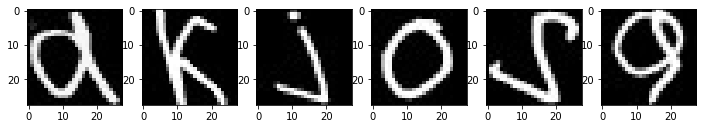

In [33]:
my_images = MyDataset('my_annot.csv', 'images\\my')
fig = plt.figure(figsize=(12, 4))

i = 1
for sample, target in my_images:
    fig.add_subplot(1, 6, i)
    plt.imshow(Image.fromarray(sample))
    i += 1

In [38]:
my_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(num_output_channels=1)
    ]
)
my_dataset = MyDataset('my_annot.csv', 'images\\my', my_transform)
my_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(my_dataset, batch_size=6), dev)

with torch.no_grad():
    for x_val, y_val in my_dataloader:
        y_pred = model3ConvNorm1(x_val)
        loss = F.cross_entropy(y_pred, y_val)
        
print(y_val)
print(torch.argmax(y_pred, dim=-1))
print(loss)

tensor([ 0, 10,  9, 14, 18, 16], device='cuda:0')
tensor([ 6, 10,  9, 14,  9, 24], device='cuda:0')
tensor(1.1169, device='cuda:0')


Перепутал 'a' и 'g', 's' и 'j', 'q' и 'y' :)

# Бонус 3 Добавьте вывод значений функции потерь и accuracy в tensorboard. 

In [27]:
!start tensorboard --logdir=runs --bind_all

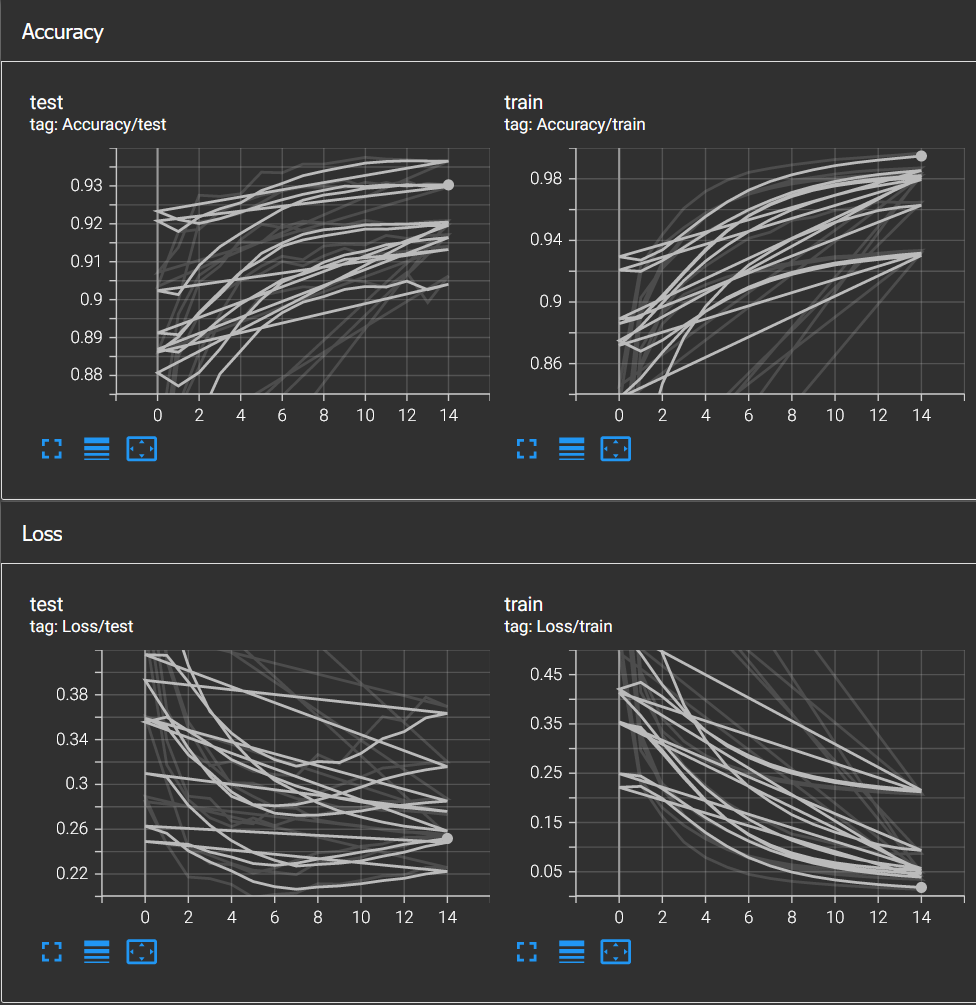